In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Outline
For efficiency the model will be functional based and run on numpy arrays.
neurons: A vector containing the voltages for each neuron from i=0 to N

weights: A connection matrix for neuron i to j. Describes how much voltages is added to neuron i when neuron j spikes. in paper, this is a i.i.d. variable that is generated at each time step. Adds randomnes to the efficiency of connections.

spikes: A record of the spikes that have occured in the network. Shape (N, n_time_steps)

## Tuneable parameters / functions
- Spiking rate function
- Distribution for neuron initialisation
- Distribution for weights (generated at each time step)
- 

## Spiking Rate 
Possible forms to explore
- Quadratic
- Linear



## TODO
- [ ] Add in a connectivity parameter

In [12]:
class Result:
    
    def convert_spike_record_to_time(self, spike_record):
        """
        Converts a bianry spike record of size (N, time_steps) into a list of arrays.
        For each neuron an array is created listing the time (seconds) at which the neuron spiked.
        N.b. the array of each neuron will
         """
        time_record = []
        for i in range(spike_record.shape[0]):
            record = np.array(np.where(spike_record[i,:] == 1)).flatten() * self.dt
            time_record.append(record)
        return time_record
    
    def last_spike(self, time_record):
        maximum = 0
        for neuron in time_record:
            length = len(neuron)
            maximum = length if length > maximum else maximum
        return maximum
            
            
    def __init__(self, spike_record, dt):
        self.spike_record = spike_record
        self.dt = dt
        self.time_record = self.convert_spike_record_to_time(spike_record)
        self.last_spike = self.last_spike(self.time_record)
        

def spiking_rate(voltage):
    """
    The spiking rate function, b(x) in the paper. If b(0) = 0 then a finite network dies. 
    Ensuring all outputs are in range [0,1] using % 1 
    :param voltage: Voltage of a neuron
    :type: float
    :return: Probability of spiking 
    : 
    """
    if voltage < 0:
        raise ValueError("voltage should be non-negative")
    return (voltage**3 * 3E9)

def get_spike_addition(i, spike_record, weights):
    """
    Given the spike_record and weights for the time step, returns the voltage to be added to neuron i 
    due to spiking neurons. 
    """
    # convert boolean array into locations
    
    spiked_j = np.array(np.where(spike_record == 1))
    spiked_j = spiked_j.flatten()
    # remove neuron if it is i
    spiked_j = np.fromiter((j for j in spiked_j if j != i), np.dtype(int))
    # multiple each j by value in weights
    added_voltage = weights[i, spiked_j]
    return sum(added_voltage)


    

def run_simulation(N=10, dt=1E-5, end_time=3):
    """
    :param N: number of neurons
    :param dt: time step lenght in seconds
    :param end_time: end time of simulation in seconds
    """
    neurons = np.zeros(N)
    neuron_rate = np.zeros(N)
    time_points = np.arange(0,end_time,dt)
    n_steps = len(time_points)
    spike_record = np.zeros((N,n_steps))
    # vecorize the spiking rate function
    spiking_rate_v = np.vectorize(spiking_rate)
    weight_matrix = np.ones((N,N))

    # Intialize the starting voltage of neurons, using gaussian with mu=1, s.d.=0.25
    # Should maybe change to truncated normal to prevent -ve values
    neurons = np.random.normal(loc=70,scale=25,size=N)


    
    for step in range(n_steps):

        # Check which neurons are spiking in this time step
        # First calculate the spiking rate at this time point for each neuron.
        # The spiking rate * the time period
        neuron_rate = spiking_rate_v(neurons) * dt
        # Calculate which have spiked and add to the array of spikes
        # If the neuron i has spiked at step n, change value of spike_record(i,n) = 1
        spike_record[:,step] = np.array(list(map(stats.bernoulli.rvs, neuron_rate)))
        # Change the voltage of spiked neurons to 0
        neurons[spike_record[:,step] == 1] = 0

        # Update the voltage of each neuron. Subtract exponential decay and then add on spiking.
        # Xi = -X(t) * dt
        neurons = neurons - neurons * dt
        # Add voltage due to spikes
        # Create a new random weight matrix
        weight_matrix = np.random.uniform(low=0, high=0.5,size=(N,N))
        for i in range(N):
            neurons[i] = neurons[i] + get_spike_addition(i, spike_record[:,step], weight_matrix)

    # Create result class and return it
    result = Result(spike_record, dt)
    return result
                          
        

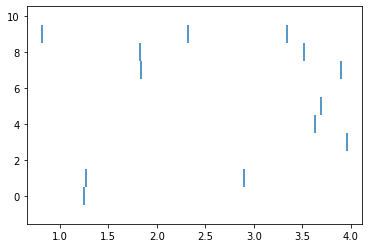

In [13]:
result = run_simulation(N=10,end_time=4, dt=1E-4)
plt.eventplot(result.time_record)
